# Imports

In [1]:
%matplotlib inline
import pandas as pd
import string
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import joblib

from scipy.spatial.distance import cdist 

from collections import Counter

from wordcloud import WordCloud

import matplotlib.cm as cm

import nltk as nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import *
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag, ne_chunk
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn import metrics 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import corpora, models

import sys
#from stop_words import get_stop_words

import csv
import _pickle as cPickle
from string import digits
import bz2
import pyLDAvis
import pyLDAvis.gensim_models

# Phase 3 - The Data Handling

In [50]:
def load_dataframe(filename):
    return pd.read_csv(filename)

def tokenizeTweets(sentance):
    words = word_tokenize(sentance)
    noise_free_words = [word for word in words if word not in Stop_words]
    return noise_free_words


def cleanPunctuation(sentance):
    new_sentance = sentance.translate(str.maketrans('', '', string.punctuation))
    new_sentance = new_sentance.replace("“","").replace("’","").replace("”","")
    return new_sentance

def cleanLinks(sentance):
    sentance = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', sentance, flags=re.MULTILINE)
    return(sentance)

def stemming(wordsList):
    #getting the root of every word for all tweets
    rootList = []
    ps = PorterStemmer()
    for w in wordsList:
        #remove the 'Retweet' tag
        if (w != 'RT'):
            rootList.append(ps.stem(w))
    return rootList


def lemmataizeSentance(wordsList):
    #getting the root of every word for all tweets
    rootList = []
    wl = WordNetLemmatizer()
    for w in wordsList:
        #remove the 'Retweet' tag
        if (w != 'RT'):
            rootList.append(wl.lemmatize(w))
    return rootList


def chunking(wordsList):
    PartsOfSpeech = pos_tag(wordsList)
    Named_entities = ne_chunk(PartsOfSpeech)
    return Named_entities

def replace_empty_to_nan(sentance, dfm , index):
    if len(sentance) == 0 :
        dfm['text'][index] = float('NaN')        
    return dfm    


def remove_nan_rows(df):
    nan_value = float("NaN")
    df.replace("", nan_value, inplace=True)
    df.dropna(subset = ["text"], inplace=True)
    return df

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


def remove_unnecessary_data(dataframe):
    dfm = df_lemmatize = df_stem = df_chunk = dataframe.copy()
    
    #remove duplicate rows
    dfm = dfm.drop_duplicates(keep='first').copy() 
    
    #removing links,emoji's, punc and tokenzing the words and making 3 dfs in 3 methods
    for i in range(0, len(df.index)):
        temp = df['text'][i].lower()
        temp = remove_emoji(temp)
        temp = cleanLinks(temp)
        temp = cleanPunctuation(temp)
        temp = tokenizeTweets(temp)
        df_stem['text'][i] = stemming(temp)
        df_lemmatize['text'][i] = lemmataizeSentance(temp)
       
        df_stem = replace_empty_to_nan(temp ,df_stem, i)
        df_lemmatize = replace_empty_to_nan(temp ,df_lemmatize, i)
    
    df_stem =  remove_nan_rows(df_stem)    
    df_lemmatize =  remove_nan_rows(df_lemmatize)    
    
             
    return df_stem , df_lemmatize
    
    
#run phase 3 - Data Handling phase 

Stop_words = set (stopwords.words('English'))
df = load_dataframe('trumpTweets.csv')
results = remove_unnecessary_data(df)
df_lemmatize = results[1]
df_stem = results[0]
df_lemmatize.to_csv("df_lemmatize_token.csv")
df_stem.to_csv("df_stem_token.csv")

C:\Users\Matan\AppData\Local\Temp/ipykernel_19848/1553001018.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stem['text'][i] = stemming(temp)
C:\Users\Matan\AppData\Local\Temp/ipykernel_19848/1553001018.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lemmatize['text'][i] = lemmataizeSentance(temp)
C:\Users\Matan\AppData\Local\Temp/ipykernel_19848/1553001018.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['text'

# Creating a vector with Doc2Vec and TFIDF & clustering with K-means algoritem


In [31]:
#Training the model & Generating the clusters - 5 Clusters
def create_clusters(df,number_of_clusters, colors ,title):
    LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
    all_content_train = []
    j=0
    for em in df['text'].values:
        all_content_train.append(LabeledSentence1(em,[j]))
        j+=1
    
    print('Number of texts processed:' , j)    
    print('this graph is from: ' , title)    

    d2v_model = Doc2Vec(all_content_train,
                        window = 10,
                        min_count = 500, 
                        workers=7,
                        dm = 1,alpha=0.025,
                        min_alpha=0.001)

    d2v_model.train(all_content_train,
                    total_examples=d2v_model.corpus_count,
                    epochs=10,
                    start_alpha=0.002,
                    end_alpha=-0.016)

    #create Clusters
    kmeans_model = KMeans(n_clusters = number_of_clusters,
                          init='k-means++', 
                          max_iter=100) 
    
    X = kmeans_model.fit(d2v_model.dv.vectors)
    
    df['cluster'] = kmeans_model.labels_
    
    
    labels=kmeans_model.labels_.tolist()
    
    l = kmeans_model.fit_predict(d2v_model.dv.vectors)
    
    #Pca - minimize the number of dimensions for visualization
    pca = PCA(n_components=2).fit(d2v_model.dv.vectors)
    datapoint = pca.transform(d2v_model.dv.vectors)
    plt.figure
    
    documents = df_stem['text'].values.astype("U")
    vectorizer = TfidfVectorizer(stop_words='english')
    features = vectorizer.fit_transform(documents)

    k = 5
    model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
    model.fit(features)
    
    #print clusters
    color = [colors[i] for i in labels]
    plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
    centroids = kmeans_model.cluster_centers_
    centroidpoint = pca.transform(centroids)
    plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
    plt.show()
    
    return X, model

# Creating color arrays in order to represent the clusters

In [32]:
#Creating the colored clusters 
# four tries to see whats better results 
four_colors = ['#FFFF00', '#008000', '#0000FF', '#800080']
five_colors = ['#FFFF00', '#008000', '#0000FF', '#800080','#00FFFF']
six_colors = ['#FFFF00', '#008000', '#0000FF', '#800080','#00FFFF','#FF7F50']
ten_colors = ['#FFFF00', '#008000', '#0000FF', '#800080','#00FFFF','#FF7F50','#FF69B4','#4B0082','#ADD8E6','#FF4500']

# Trying Both Stemming & Lemmatizing With Doc2Vec Clusters

In [41]:
df_lemmatize_Doc2Vec = pd.read_csv("df_lemmatize_token.csv")
df_stem_Doc2Vec = pd.read_csv("df_stem_token.csv")

# With Stemming

Number of texts processed: 55253
this graph is from:  df_stem


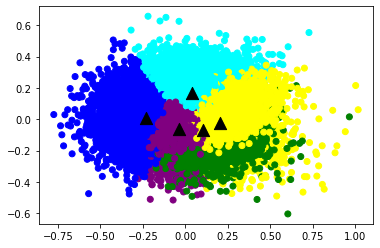

In [42]:
#Created a cluster of doc2vec & kmeans - 5 clusters
df_stem_five_cluster = create_clusters(df_stem_Doc2Vec, 5, five_colors, 'df_stem')

# With Lemmatizing

Number of texts processed: 55253
this graph is from:  df_lemmatize


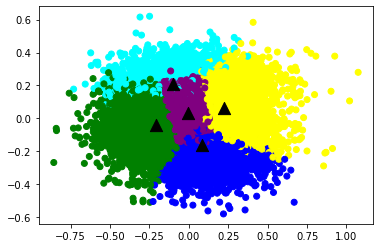

In [43]:
#Created a cluster of doc2vec & kmeans - 5 clusters
df_lem_five_cluster = create_clusters(df_lemmatize_Doc2Vec, 5, five_colors, 'df_lemmatize')

# Creating TFIDF Clusters:
## Printing The Dominating Words In Each Cluster
## Summing Up Each Clusters Likes & ReTweets 
## Printing The Clusters As a Graph

## With Stemming:

In [44]:
#TfIDF and clustering - stemming
documents = df_stem_Doc2Vec['text'].values.astype("U")
vectorizer = TfidfVectorizer(stop_words='english')
features = vectorizer.fit_transform(documents)

k = 5
model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
model.fit(features)

KMeans(max_iter=100, n_clusters=5, n_init=1)

## Printing The Word Clusters  & The Amount Of Likes and Retweets

In [99]:
df_stem_Doc2Vec['cluster'] = model.labels_

clusters = df_stem_Doc2Vec.groupby('cluster')    
print("Cluster centroids: \n")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

likes_stem = [0,0,0,0,0]
retweets_stem = [0,0,0,0,0]
for i in range(0, len(df_stem_Doc2Vec.index)):
    if df_stem_Doc2Vec['cluster'][i] == 0:
        likes_stem[0]+=df_stem_Doc2Vec['favorites'][i]
        retweets_stem[0]+=df_stem_Doc2Vec['retweets'][i]
    if df_stem_Doc2Vec['cluster'][i] == 1:
        likes_stem[1]+=df_stem_Doc2Vec['favorites'][i]
        retweets_stem[1]+=df_stem_Doc2Vec['retweets'][i]
    if df_stem_Doc2Vec['cluster'][i] == 2:
        likes_stem[2]+=df_stem_Doc2Vec['favorites'][i]
        retweets_stem[2]+=df_stem_Doc2Vec['retweets'][i]
    if df_stem_Doc2Vec['cluster'][i] == 3:
        likes_stem[3]+=df_stem_Doc2Vec['favorites'][i]
        retweets_stem[3]+=df_stem_Doc2Vec['retweets'][i]
    if df_stem_Doc2Vec['cluster'][i] == 4:
        likes_stem[4]+=df_stem_Doc2Vec['favorites'][i]
        retweets_stem[4]+=df_stem_Doc2Vec['retweets'][i]        

for i in range(k):
    print("Cluster %d:" % i)
    for j in order_centroids[i, :10]: #print out 10 feature terms of each cluster
        print (' %s' % terms[j])
    print('------------')
    
for i in range(k):
    print("Cluster %d:" % i)
    print("Likes = %d" % likes_stem[i])
    print("Retweets = %d" % retweets[i])
    print('------------')

Cluster centroids: 

Cluster 0:
 rt
 thank
 trump
 people
 president
 new
 obama
 country
 time
 big
------------
Cluster 1:
 great
 america
 make
 job
 thank
 realdonaldtrump
 people
 state
 country
 honor
------------
Cluster 2:
 realdonaldtrump
 rt
 president
 trump
 run
 thanks
 need
 thank
 donald
 love
------------
Cluster 3:
 democrat
 news
 fake
 medium
 rt
 republican
 want
 people
 house
 impeachment
------------
Cluster 4:
 amp
 thanks
 great
 rt
 trump
 people
 realdonaldtrump
 country
 new
 job
------------
Cluster 0:
Likes = 917072249
Retweets = 273347340
------------
Cluster 1:
Likes = 198474593
Retweets = 90927364
------------
Cluster 2:
Likes = 5649211
Retweets = 38119886
------------
Cluster 3:
Likes = 228642326
Retweets = 63208560
------------
Cluster 4:
Likes = 153453018
Retweets = 41674347
------------


## Printing The Clusters Scatter Plot - X = Retweets, Y = Likes

Text(0.5, 1.0, 'X = Likes, Y = Retweets, In 100M Scale')

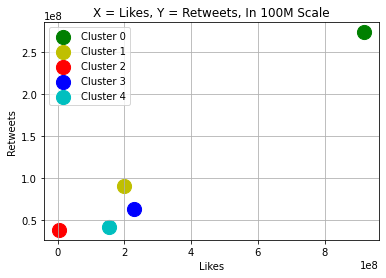

In [143]:
from importlib import reload
plt=reload(plt)
plt.scatter(likes[0],retweets[0],color='g', s=200, label='Cluster 0')
plt.scatter(likes[1],retweets[1],color='y', s=200,label='Cluster 1')
plt.scatter(likes[2],retweets[2],color='r', s=200, label='Cluster 2')
plt.scatter(likes[3],retweets[3],color='b', s=200, label='Cluster 3')
plt.scatter(likes[4],retweets[4],color='c', s=200, label='Cluster 4')
plt.legend()
plt.grid()
plt.xlabel('Likes')
plt.ylabel('Retweets')
plt.title('X = Likes, Y = Retweets, In 100M Scale')

## With Lemmatizing:

In [46]:
#TfIDF and clustering - lemmetzing
documents = df_lemmatize_Doc2Vec['text'].values.astype("U")
vectorizer = TfidfVectorizer(stop_words='english')
features = vectorizer.fit_transform(documents)

k = 5
model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
model.fit(features)

KMeans(max_iter=100, n_clusters=5, n_init=1)

## Printing The Word Clusters

In [101]:
df_lemmatize_Doc2Vec['cluster'] = model.labels_

clusters = df_lemmatize_Doc2Vec.groupby('cluster')    
print("Cluster centroids: \n")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

        
likes_lem = [0,0,0,0,0]
retweets_lem = [0,0,0,0,0]
for i in range(0, len(df_lemmatize_Doc2Vec.index)):
    if df_lemmatize_Doc2Vec['cluster'][i] == 0:
        likes_lem[0]+=df_lemmatize_Doc2Vec['favorites'][i]
        retweets_lem[0]+=df_lemmatize_Doc2Vec['retweets'][i]
    if df_lemmatize_Doc2Vec['cluster'][i] == 1:
        likes_lem[1]+=df_lemmatize_Doc2Vec['favorites'][i]
        retweets_lem[1]+=df_lemmatize_Doc2Vec['retweets'][i]
    if df_lemmatize_Doc2Vec['cluster'][i] == 2:
        likes_lem[2]+=df_lemmatize_Doc2Vec['favorites'][i]
        retweets_lem[2]+=df_lemmatize_Doc2Vec['retweets'][i]
    if df_lemmatize_Doc2Vec['cluster'][i] == 3:
        likes_lem[3]+=df_lemmatize_Doc2Vec['favorites'][i]
        retweets_lem[3]+=df_lemmatize_Doc2Vec['retweets'][i]
    if df_lemmatize_Doc2Vec['cluster'][i] == 4:
        likes_lem[4]+=df_lemmatize_Doc2Vec['favorites'][i]
        retweets_lem[4]+=df_lemmatize_Doc2Vec['retweets'][i]        

for i in range(k):
    print("Cluster %d:" % i)
    for j in order_centroids[i, :10]: #print out 10 feature terms of each cluster
        print (' %s' % terms[j])
    print('------------')
    
for i in range(k):
    print("Cluster %d:" % i)
    print("Likes = %d" % likes_lem[i])
    print("Retweets = %d" % retweets_lem[i])
    print('------------')

Cluster centroids: 

Cluster 0:
 rt
 thank
 trump
 people
 president
 new
 obama
 country
 time
 big
------------
Cluster 1:
 great
 america
 make
 job
 thank
 realdonaldtrump
 people
 state
 country
 honor
------------
Cluster 2:
 realdonaldtrump
 rt
 president
 trump
 run
 thanks
 need
 thank
 donald
 love
------------
Cluster 3:
 democrat
 news
 fake
 medium
 rt
 republican
 want
 people
 house
 impeachment
------------
Cluster 4:
 amp
 thanks
 great
 rt
 trump
 people
 realdonaldtrump
 country
 new
 job
------------
Cluster 0:
Likes = 917072249
Retweets = 273347340
------------
Cluster 1:
Likes = 198474593
Retweets = 45463682
------------
Cluster 2:
Likes = 5649211
Retweets = 38119886
------------
Cluster 3:
Likes = 228642326
Retweets = 63208560
------------
Cluster 4:
Likes = 153453018
Retweets = 41674347
------------


## Printing The Clusters Scatter Plot - X = Retweets, Y = Likes

Text(0.5, 1.0, 'X = Likes, Y = Retweets, In 100M Scale')

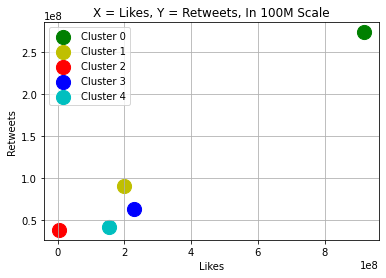

In [142]:
from importlib import reload
plt=reload(plt)
plt.scatter(likes[0],retweets[0],color='g', s=200, label='Cluster 0')
plt.scatter(likes[1],retweets[1],color='y', s=200,label='Cluster 1')
plt.scatter(likes[2],retweets[2],color='r', s=200, label='Cluster 2')
plt.scatter(likes[3],retweets[3],color='b', s=200, label='Cluster 3')
plt.scatter(likes[4],retweets[4],color='c', s=200, label='Cluster 4')
plt.legend()
plt.grid()
plt.xlabel('Likes')
plt.ylabel('Retweets')
plt.title('X = Likes, Y = Retweets, In 100M Scale')

## Using LDA Algorithem With Both Stemming & Lemmatizing To Compare The LDA Module & The TFIDF Module Word Clusters 

## With Lemmatizing:

In [51]:
#Creating LDA clusters of the tweets - 5 topics
lem_dictionary = corpora.Dictionary(df_lemmatize['text'])
lem_corpus = [lem_dictionary.doc2bow(text) for text in df_lemmatize['text']]
lem_lda = gensim.models.ldamulticore.LdaMulticore(lem_corpus, id2word=lem_dictionary, num_topics=5, chunksize=1000, passes=20, workers=30)

### The Slide Bar:
1 = The frequensey that the word accured in the cluster
      ,0 = The frequensey that the word accured in corpus divided by all the words in the corpus


In [52]:
#Printing the clusters with lda_vis
let_lda_vis = pyLDAvis.gensim_models.prepare(lem_lda, lem_corpus, lem_dictionary)
pyLDAvis.display(let_lda_vis)


C:\Users\Matan\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


## With Stemming:

In [8]:
#Creating LDA clusters of the tweets - 5 topics
st_dictionary = corpora.Dictionary(df_stem['text'])
st_corpus = [st_dictionary.doc2bow(text) for text in df_stem['text']]
st_lda = gensim.models.ldamulticore.LdaMulticore(st_corpus, id2word=st_dictionary, num_topics=5, chunksize=1000, passes=20, workers=30)

In [9]:
#Printing the clusters with lda_vis
st_lda_vis = pyLDAvis.gensim_models.prepare(st_lda, st_corpus, st_dictionary)
pyLDAvis.display(st_lda_vis)
